# WorldPop Raster Processing Notebook
 
**Purpose**  
This Jupyter notebook clips several WorldPop raster (.tif) layers to an Area of Interest (AOI), stacks them into a single multi‑band composite file, and then also aggregates bands into user‑defined age groups for future analysis & visualisation in GIS software using the accompanying 'arcgis_zonal_stats_pop_pyramids' notebook.
 
**Main steps to the notebook**
 1. Install / import libraries
 2. Define paths & create output folders
 3. Load AOI
 4. Extract metadata from the filename
 5. Clip rasters to the AOI
 6. Stack clipped rasters to create a multi‑band composite
 7. Load the composite as an Xarray
 8. Define custom age groups and aggregate
 9. Visualise the grouped layers
 10. Export the grouped rasters

**Save this notebook into an empty folder. Step 2 will create the necessary folder structure in the same location where this notebook is saved**

Tifs and AOI should then be saved in their respective folders (detailed below) after running Step 2, before progressing any further in the notebook.


**Folder structure (relative paths) should appear as below after running Step 2**
```
 project_root/
├── input_rasters/        # Save WorldPop Age and Gender Population Structures .tif files here, from [Humanitarian Data Exchange](https://data.humdata.org/organization/worldpop?dataseries_name=WorldPop+-+Age+and+Gender+Population+Structures), ensure these are unzipped!
├── AOI/
│   └── main_aoi.shp or main.geojson
├── clipped_rasters # Output clipped rasters will be saved here
├── composite_raster/     # Output composites will be written here
└── world_pop_processing_rev4.ipynb  # This Jupyter notebook script
```


# Tif filename assumptions, as downloaded from WorldPop
 * File format: `<3 letter country code>_<gender>_<age>_2025_CN_100m_R2024B_v1.tif`
 * `<gender>` expects one of `f`, `m`, or `t` (female, male, total)
 * `<age>` expects a two-digit age bracket, e.g. `00`, `01`, ..., `90`

# Workflow assumptions
It is assumed that the output composite from this notebook will be further processed using 'arcgis_zonal_stats_rev3' notebook, which is written specifically to be run in ArcGIS Pro.
The ArcGIS notebook will utilise the composites created during this notebook to extract zonal statistics for the overall AOI, as well as smaller areas (expected output is several CSVs). It will then create population pyramids from the CSVs generated by the zonal statistics script (the expected output is several PNGs).
 


###### Version: rev4 Author: Maria Fedyszyn, Last updated: 18/08/2025.


# Setting up an environment with the Anaconda Prompt

Create a new environment using the accompanying environment.yaml. An easy way to do this is from the Anaconda Prompt.

Run the following:


`conda env create --name world_pop --file "C:\ETC\environment.yml" ` < - change this to your pathway !


then


`conda activate world_pop_analysis`


then 


`python -m ipykernel install --user --name=world_pop_analysis --display-name "Python (world_pop_analysis)"`

Once this is done, select world_pop as the kernel in the notebook, as seen in the image below, circled in red
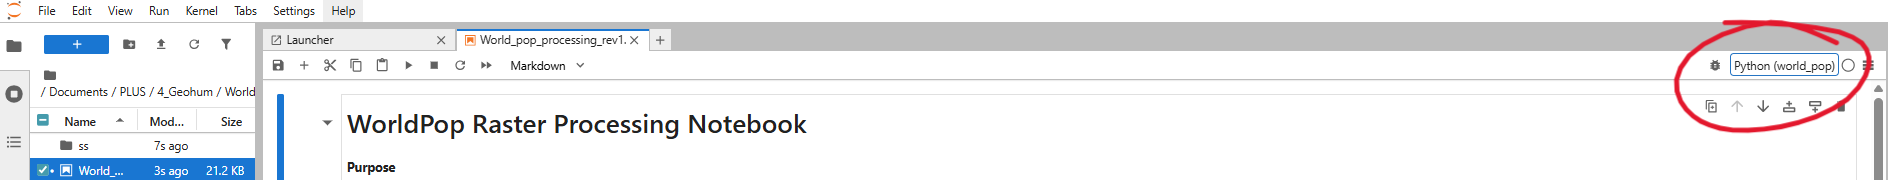



# 1. Import libraries

In [ ]:
from collections import OrderedDict
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import re
import rasterio
from rasterio.mask import mask
import rioxarray
from shapely.geometry import mapping
from tqdm.auto import tqdm
import xarray as xr

### Activate inline plotting (if running in Jupyter)
Ensure inline display of plots when running in a Jupyter environment; silently skip if not applicable.

In [ ]:
try:
    get_ipython()  # type: ignore
    %matplotlib inline
except Exception:
    pass

# 2. Define paths & create output folders
If the notebook is being run in a different folder than where all the outputs should be saved, then modify 'project_root'.
The cell then goes on to create the folders where all inputs and outputs should be saved.

In [ ]:
project_root = Path(".")  # or Path("/full/path/to/your/project") if running elsewhere

ROOT = Path.cwd()
dirs = ["input_rasters", "AOI", "composite_raster", "clipped_rasters"]

# Create directories and assign to variables in one go
INPUT_DIR, AOI_DIR, OUTPUT_DIR, CLIPPED_DIR = [(ROOT / d).mkdir(exist_ok=True) or (ROOT / d) for d in dirs]

print(f"Input rasters : {INPUT_DIR}")
print(f"AOI path      : {AOI_DIR}")  
print(f"Output dir    : {OUTPUT_DIR}")
print(f"Clipped dir   : {CLIPPED_DIR}")

# 3. Load AOI

## Important: Check that the AOI CRS matches that of the WorldPop data. You can do this by loading the file in GIS software and checking the CRS there. If not EPSG: 4326, uncomment the code to reproject the AOI accordingly.

In [ ]:
vector_files = list(AOI_DIR.glob("*.shp")) + list(AOI_DIR.glob("*.geojson"))
assert vector_files, "No vector file found in AOI directory! Check the file type of the target AOI"
AOI_PATH = vector_files[0]
print(f"Using AOI file: {AOI_PATH.name}")

#read the AOI
aoi_gdf = gpd.read_file(AOI_PATH)

# Set the CRS of the AOI
aoi_gdf = aoi_gdf.set_crs("EPSG: 4326")  # Update to match your actual source CRS if different

#reproject if necessary to match world pop data
#aoi_gdf = aoi_gdf.to_crs("EPSG: 4326") # uncomment this line to reproject!
AOI_GEOMS = [mapping(geom) for geom in aoi_gdf.geometry]

# 4. Extract metadata from filename
This step allows for the bands to be saved with the respective category names

Streamlined regex (regular expression to match sepcific filename structure) for WorldPop filenames: {country}_{gender}_{age}_{year}_CN_100m_R2024B_v1.tif

In [ ]:
FILENAME_REGEX = re.compile(r'^[a-z]{3}_([fmt])_(\d{2})_\d{4}_CN_100m_R\d{4}B_v\d+\.tif$')

def extract_metadata(path):
    """Extract gender and age from WorldPop filename."""
    filename = path.name if hasattr(path, 'name') else Path(path).name
    
    match = FILENAME_REGEX.match(filename)
    if not match:
        raise ValueError(f"Invalid filename format: {filename}")
    
    return match.group(1), int(match.group(2))

Creates another regex to allow for reading the clipped files too

In [ ]:
CLIPPED_FILENAME_REGEX = re.compile(r"([fmt])_age_(\d{2})(?:_clipped)?\.tif")

def extract_clipped_metadata(path):
    """Extract gender and age from clipped filename."""
    filename = path.name if hasattr(path, 'name') else Path(path).name
    match = CLIPPED_FILENAME_REGEX.match(filename)
    if not match:
        raise ValueError(f"Invalid filename format: {filename}")
    return match.group(1), int(match.group(2))

# 5. Clip rasters to the AOI

Loops through all input `.tif` files, extracts the metadata (gender and age), and clips each raster to the AOI boundary. 
Clipped rasters are saved with standardised filenames and reused if already processed. All clipped paths are stored for stacking in the next step.

In [ ]:
raster_files = sorted(INPUT_DIR.glob("*.tif"), key=lambda p: extract_metadata(p)[1])
assert raster_files, "No .tif files found in input_rasters directory."
clipped_paths = [] 
for src_path in tqdm(raster_files, desc="Clipping rasters"):
    gender, age = extract_metadata(src_path)
    out_name = f"{gender}_age_{age:02d}_clipped.tif"
    dst_path = CLIPPED_DIR / out_name

    if dst_path.exists():
        clipped_paths.append(dst_path)
        continue

    with rasterio.open(src_path) as src:
        out_image, out_transform = mask(
            src,
            AOI_GEOMS,
            crop=True,
            nodata= -9999,
            filled=True,
            all_touched=True
        )
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": -9999,
            "dtype": "float32"
        })

        with rasterio.open(dst_path, "w", **out_meta) as dst:
            dst.write(out_image.astype("float32"))

    clipped_paths.append(dst_path)

print(f"Total clipped rasters: {len(clipped_paths)}")

# 6. Stack clipped rasters to create multi‑band composite

Creates a multi-band raster by stacking all clipped rasters into a single composite file. 
Each band corresponds to a specific age and gender group, with descriptive metadata added for clarity.
It will automatically skip this step if the composite file already exists.

In [ ]:
composite_path = OUTPUT_DIR / "composite.tif"
if not composite_path.exists():
    first = rasterio.open(clipped_paths[0])
    meta = first.meta.copy()
    meta.update(count=len(clipped_paths))
    with rasterio.open(composite_path, "w", **meta) as dst:
        for idx, layer_path in enumerate(clipped_paths, start=1):
            with rasterio.open(layer_path) as src:
                dst.write(src.read(1), idx)
            gender, age = extract_clipped_metadata(layer_path)
            dst.set_band_description(idx, f"{gender}_age_{age:02d}")
    print(f"Composite written to {composite_path}")
else:
    print("Composite already exists → skipping stack step.")

# 7. Load the composite as an Xarray

Opens the composite raster as an xarray DataArray and masks out no-data values. 
Assigns meaningful labels to each band (e.g., "f_age_05") to make future referencing and analysis easier.

In [ ]:
print("Opening all clipped rasters lazily with Dask...")

# Extract band labels and open rasters lazily
arrays = []
labels = []

for p in tqdm(clipped_paths, desc="Preparing rasters", ncols=80):
    gender, age = extract_clipped_metadata(Path(p))
    labels.append(f"{gender}_age_{age:02d}")
    
    da = rioxarray.open_rasterio(
        p,
        masked=True,                # respect nodata if in metadata
        chunks={"x": 1024, "y": 1024}  # dask chunking to avoid memory issues
    )
    arrays.append(da)

print("Concatenating rasters along 'band' dimension...")
composite_da = xr.concat(arrays, dim="band").assign_coords(band=labels)

# If nodata is NOT in the raster metadata, mask explicitly (still lazy)
composite_da = composite_da.where(composite_da != -9999)

print("All rasters opened, masked, and labeled.")

# 8. Define custom age groups and aggregate

Checks what ages are available in the data, these can then be used in the code chunk below

In [ ]:
ages_in_data = []
for label in composite_da.band.values:
    gender, age = label.split("_age_")
    ages_in_data.append(int(age))

print("Ages in your data:", sorted(set(ages_in_data)))

In [ ]:
def get_band_indices(age_range, gender_filter="t"):
    indices = []
    for i, label in enumerate(composite_da.band.values):
        gender, age = label.split("_age_")
        if int(age) in age_range and (gender_filter is None or gender == gender_filter):
            indices.append(label)
    return indices

# Modify this to what is required for the project; comment/uncomment/create groups as needed or add custom groupings.
age_groups = {
    "all": [0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90], # overview
    "children": [0, 1, 5],                        # 0-5 years
    "under_15": [0, 1, 5, 10],                # 0-15 years
    "youth": [10, 15, 20],                        # 10-20 years
    "adults": [25, 30, 35, 40, 45, 50, 55],       # 25-55 years
    "seniors": [60, 65, 70, 75, 80, 85, 90],       # 60+ years
}

aggregated = {}
for group_name, age_range in age_groups.items():
    band_ids = get_band_indices(age_range)
    if not band_ids:
        print(f"Warning: no matching bands for {group_name}")
        continue
    aggregated[group_name] = composite_da.sel(band=band_ids).sum(dim="band")

agg_ds = xr.Dataset(aggregated)

## Proportion of the total population that is <15 years old
This calculation uses only **t_age_∗** (total) bands to prevent double‑counting. Current ages considered: 0, 1, 5, 10 (i.e. <15). This can be modified to a range of your choosing.
The result is a float raster (0–1); multiply this by 100 for a percentage when visualising. Note that the output of this will be the same within administrative boundaries, and so variation within the AOI may be minimal or none.

In [ ]:
# pick total‑population bands under 15
under15_ids = [b for b in composite_da.band.values
               if b.startswith("t_age_") and int(b.split("_age_")[1]) < 15]

# sum them → people <15
under15 = composite_da.sel(band=under15_ids).sum(dim="band")

# total population (all t_age_∗)
total_ids = [b for b in composite_da.band.values if b.startswith("t_age_")]
total_pop = composite_da.sel(band=total_ids).sum(dim="band", skipna=True)

# proportion, guarding against divide‑by‑zero
prop_under15 = xr.where(total_pop > 0, under15 / total_pop, 0).assign_attrs({
    "long_name": "Proportion_of_population_under_15",
    "units": "ratio (0‑1)"
})

# add to aggregated dictionary and dataset
aggregated["prop_under15"] = prop_under15
# agg_ds["prop_under15"] = prop_under15

print("prop_under15 raster added to agg_ds")

# 9. Visualise the grouped layers

Generates a plot for each aggregated age group raster. Displays the layer with a formatted title and no axis ticks for a cleaner presentation. This is simply for a visual assessment within this notebook and does not create any outputs. 

**Do not run if assessing on or near to a country level, it will likely crash the notebook!**

In [ ]:
for name, da in aggregated.items():
    plt.figure(figsize=(6, 6))
    da.plot()
    plt.title(name.replace("_", " ").title())
    plt.axis('off')
    plt.show()

# 10. Export the grouped rasters

Prepares and exports all aggregated rasters to GeoTIFF format, preserving order and ensuring each has a defined CRS.  
Skips export for files that already exist to avoid overwriting.

In [ ]:
rasters_to_export = OrderedDict(aggregated)  # preserves order

for name, da in rasters_to_export.items():
    out_path = OUTPUT_DIR / f"{name}.tif"
    if out_path.exists():
        print(f"Skipped (already exists): {out_path.name}")
        continue

    if not da.rio.crs:
        da = da.rio.write_crs("EPSG:4326")

    # Export
    da.rio.to_raster(out_path)
    print(f"Saved: {out_path.name}")

print("All grouped rasters exported.")

# Some **optional** quality control chunks for the composites
The following chunks do not need to be run, they are simply for QC if you are questioning the data!

The code prints debug information for each user-defined age group, lists the selected band indices and outputs basic statistics (shape, value range, sum) to verify the correctness of the grouping.
Ensure that the data range does not go below 0 and that the sum is a positive value. If not, it is indicative that masking 'no values' has been unsuccessful.

In [ ]:
for group_name, age_range in age_groups.items():
    band_ids = get_band_indices(age_range)
    print(f"{group_name}: {band_ids}")
    
    if band_ids:
        selected_data = composite_da.sel(band=band_ids)
        print(f"  - Shape: {selected_data.shape}")
        print(f"  - Data range: {selected_data.min().values} to {selected_data.max().values}")
        print(f"  - Sum: {selected_data.sum().values}")
    print()

Iterates through each band in the composite raster and prints the sum of its values.  
Helps identify missing or anomalous data across individual age-gender bands.
Again, ensure no values are negative.

In [ ]:
for i, label in enumerate(composite_da.band.values):
    data_slice = composite_da.isel(band=i)
    data_sum = data_slice.sum().values
    print(f"Band {i} ({label}): sum = {data_sum}")

Defines a debug version of the band index selector that prints gender and age checks for each band.  
The code tests selection within a specific age range to verify filtering logic and ensure no unintended gender filtering occurs.
Based on the current selection, only bands for ages 10, 15 and 20 should be True and all others False. If this is not the case, review the regex chunks.

In [ ]:
def get_band_indices_debug(age_range, gender_filter=None):
    indices = []
    for i, label in enumerate(composite_da.band.values):
        gender, age = label.split("_age_")
        age_int = int(age)
        print(f"Checking {label}: gender={gender}, age={age_int}, in_range={age_int in age_range}")
        if age_int in age_range and (gender_filter is None or gender == gender_filter):
            indices.append(label)
    return indices

band_ids = get_band_indices_debug([10, 15, 20])
print(f"Found bands: {band_ids}")